In [22]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import math
import cmath
import scipy
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.special as special
import numpy.ma as ma
#np.set_printoptions(threshold=sys.maxsize)
pts = 5000 # number of iterator steps where neccessary
H_to_K = 1/0.000003166808534191 # conversion of Henries to Kelvin
tol = 1e-6 # tolerance where neccessary

In [24]:
r = np.linspace(4,60, pts) # range of r values to iterate over, 4 -> 60 Bohr radii
dr = r[1] - r[0] # spacing dr
C12 = 3.05e8 # C12 coefficient in Eh*ao
C6 = 4710 # C6 coefficient in Eh*ao
Vr = (C12/(r**12)) - (C6/(r**6)) # standard Lennard-Jones interatomic potential
Eo = 3.166808534191e-12 # inital particle energy, 1uK in Hartrees
me = 9.1093837e-28 # electron mass in grams
mrb_g = 1.4192261e-22 # rubidium mass in grams
mrb = mrb_g/me # rubidium mass in au
mu = (mrb**2)/(2*mrb) # reduced mass of rubidium
hbar = 1.0546e-27 # reduced Planck constant in cgs
e = 4.8032e-10 # electron charge in cgs
ao = (hbar**2)/(me*e**2) # Bohr radius in cgs

# Generic DVR for finding bound states (E < 0)
### for a coordinate x in a 'box' from a to b, we can use r from r1 to r2, where r1 is small enough to see the wave function diminish to zero and r2 large enough to get all the bound states

## $ x \in (a,b) $, $x_{i} = a + \frac{(b-a)i}{N}, i = 1,2,..,N-1$, $dx = \frac{(b-a)}{N}$

## $ T_{ij} = \frac{1}{2} \frac{(-1)^{i-j}}{(b-a)^2} \frac{\pi^2}{2} [\frac{1}{sin^2(\frac{\pi (i-j)}{2N})} - \frac{1}{sin^2(\frac{\pi (i+j)}{2N})}] $
## $ T_{ii} = \frac{1}{(b-a)^2} \frac{\pi^2}{4} [\frac{2N^2 + 1}{3} - \frac{1}{sin^2(\frac{\pi i}{N})}]$
## $ V_{ii} = V(x_i) $
## $ H_{ii} = T_{ii} + V_{ii}$
## $ H_{ij} = T_{ij}$

## $H_{ii} = \frac{1}{(b-a)^2} \frac{\pi^2}{4 \mu} [\frac{2N^2 + 1}{3} - \frac{1}{sin^2(\frac{\pi i}{N})}] + \frac{C_{12}}{r_{i}^{12}} - \frac{C_{6}}{r_{i}^6} $
## $ H_{ij} = \frac{(-1)^{i-j}}{(b-a)^2} \frac{\pi^2}{4\mu} [\frac{1}{sin^2(\frac{\pi (i-j)}{2N})} - \frac{1}{sin^2(\frac{\pi (i+j)}{2N})}] $

In [37]:
def Hamiltonian_DVR(a, b, dx): # DVR method for finding bound states
    N = int((b-a)/dx) # Number of grid points
    ipaper = np.arange(1,N, 1.0) # indexing from the paper, given i = 1,2,...,N-1
    x = a + dx*ipaper # grid from paper
    Vx = C12/(x**12) - C6/(x**6) # Lennard-Jones potential
    Vx = np.insert(Vx,0,0) # Insert a 0 at the 0th index of list to account for mismatched indexing

    #print(f' ipaper = {ipaper}')
    #print(f' x = {x}')
    print(f' N - 1 = {N-1}')
    #print(f' len(x) = {len(x)}')
    #print(x[-1]/(b-dx))
    #print(x[0]/(a+dx))
    #print(f' dx = {dx}')
    #print(f'dx from grid  = {x[1] - x[0]}')
    #print(Vx[len(Vx) - 1]/(0.5*(b - dx - d)**2))

    H_DVR = np.zeros((len(x), len(x))) # Initialize empty Hamiltonian matrix of size N-1 x N-1
    Vmat = np.zeros((len(x) + 10, len(x) + 10))
    Tmat = np.zeros((len(x) + 10, len(x) + 10))


    for i in ipaper:
        for j in ipaper:
            if int(i) == int(j): # fill in diagonal components of the Hamiltonian
                prefactorii = (np.pi**2)/(4*mu*(b-a)**2)
                bracketii = ((2*N**2 + 1)/3) - (1/((np.sin(np.pi*(i/N)))**2))
                
                Tmat[int(i)][int(j)] = prefactorii*bracketii
                Vmat[int(i)][int(j)] = Vx[int(j)]
                
                H_DVR[int(i) - 1][int(j) - 1] = Tmat[int(i)][int(j)] + Vmat[int(i)][int(j)]
            
            if i != j: # fill in off-diagonal components of the Hamiltonian
                diff = i - j
                prefactorij = ((-1)**(diff))*(np.pi**2)/(4*mu*(b-a)**2)
                bracketij = (1/((np.sin(np.pi*((diff)/(2*N))))**2)) - (1/((np.sin(np.pi*((i+j)/(2*N))))**2))
                Tmat[int(i)][int(j)] = prefactorij*bracketij               
                
                H_DVR[int(i) - 1][int(j) - 1] = Tmat[int(i)][int(j)]
                
    #assert(np.allclose(H_DVR, np.transpose(H_DVR)))
    #print(f' H = {H}')
    return H_DVR

In [ ]:
a1 = 4.5
b1 = 100
dx1 = 0.01

N1 = int((b1-a1)/dx1) # Number of grid points
ipap = np.arange(1,N1, 1.0) # indexing from the paper, given i = 1,2,...,N-1
x1 = a1 + dx1*ipap


VLJ = C12/(x1**12) - C6/(x1**6)
Vmin = min(VLJ)

H = Hamiltonian_DVR(a1, b1, dx1)

In [ ]:
Heig = np.linalg.eigh(H)[0]
print(f'there are {len(Heig[Heig<0])} bound states')

Eigvec = np.linalg.eigh(H)[1]
Hvec = []
for i in range(len(H[0])):
    avec = Eigvec[:,i]
    Hvec.append(avec)
for i in range(len(Hvec)):
    INT = np.trapz(np.abs(Hvec[i])**2,x1)
    A = 1/np.sqrt(INT)
    Hvec[i] = A*Hvec[i]

# Normalization check for bound eigenstates
# $ \braket{\varphi_{n}|\varphi_{m}} = \delta_{nm} = \int_a^b \varphi^*_{n}\varphi_{m}\,dx$

In [41]:
for i in range(len(Heig[Heig < 0])): # run through all eigenvectors corresponding to bound states
    for j in range(len(Heig[Heig < 0])): # run through all other eigenvectors corresponding to bound states
        
        if i == j: # inner product should be close to 1
            phi_n = np.conjugate(Hvec[i])
            phi_m = Hvec[j]
            produit = phi_n*phi_m
            InnerProduct = np.trapz(produit, x1)
            assert(InnerProduct - 1 <= tol)

        if i != j: # inner product should be close to 0
            phi_n = np.conjugate(Hvec[i])
            phi_m = Hvec[j]
            produit = phi_n*phi_m
            InnerProduct = np.trapz(produit, x1)
            assert(InnerProduct <= tol)

NameError: name 'Heig' is not defined

# DVR example - Lennard Jones

In [80]:
a1 = 4.5
b1 = 100
dx1 = 0.01

N1 = int((b1-a1)/dx1) # Number of grid points
ipap = np.arange(1,N1, 1.0) # indexing from the paper, given i = 1,2,...,N-1
x1 = a1 + dx1*ipap


VLJ = C12/(x1**12) - C6/(x1**6)
Vmin = min(VLJ)

H = Hamiltonian_DVR(a1, b1, dx1)

 N - 1 = 9549


In [81]:
Heig = np.linalg.eigh(H)[0]
print(f'for b = {b1}, there are {len(Heig[Heig<0])} bound states')
Eigvec = np.linalg.eigh(H)[1]
Hvec = []
for i in range(len(H[0])):
    avec = Eigvec[:,i]
    Hvec.append(avec)
for i in range(len(Hvec)):
    INT = np.trapz(np.abs(Hvec[i])**2,x1)
    A = 1/np.sqrt(INT)
    Hvec[i] = A*Hvec[i]

for b = 100, there are 90 bound states


(5.0, 14.0)

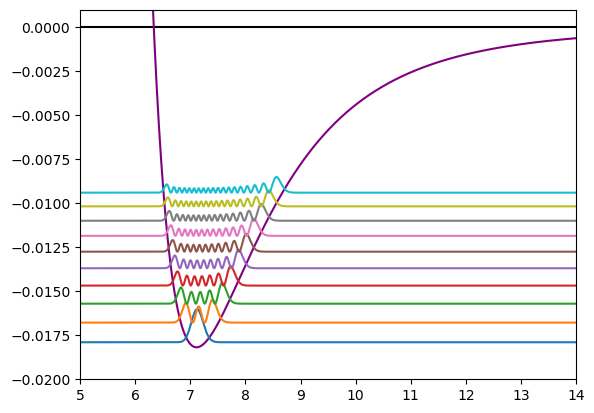

In [112]:
plt.hlines(0,min(x1), max(x1), color = 'black')
plt.plot(x1, VLJ, color = 'purple')
for i in range(20):
    if i % 2 == 0:
        plt.plot(x1, 0.0005*np.abs(Hvec[i])**2 + Heig[i], label=f'n={i}')

plt.ylim(-0.02, 0.001)
plt.xlim(5,14)
#plt.legend()

In [114]:
for i in range(len(Heig[Heig < 0])): # run through all eigenvectors corresponding to bound states
    for j in range(len(Heig[Heig < 0])): # run through all other eigenvectors corresponding to bound states
        
        if i == j: # inner product should be close to 1
            phi_n = np.conjugate(Hvec[i])
            phi_m = Hvec[j]
            produit = phi_n*phi_m
            InnerProduct = np.trapz(produit, x1)
            assert(InnerProduct - 1 <= tol)

        if i != j: # inner product should be close to 0
            phi_n = np.conjugate(Hvec[i])
            phi_m = Hvec[j]
            produit = phi_n*phi_m
            InnerProduct = np.trapz(produit, x1)
            assert(InnerProduct <= tol)

# Numerov Algorithm for continuum states (E > 0)

## Schrodinger in au: -$\frac{1}{2\mu  }\frac{d^2\psi}{dr^2} + (\frac{l(l+1)}{2\mu r^2} + V(r))\psi = E\psi$ 
## $\psi'' = -2\mu(E - \frac{l(l+1)}{2\mu r^2} - V(r))\psi$
## $\implies \psi'' + 2\mu(E - \frac{l(l+1)}{2\mu r^2} - V(r))\psi = 0$
## $\psi'' + k^2(r)\psi = 0$
## define  $k^2(r) = 2\mu(E - V(r) - \frac{l(l+1)}{2\mu r^2})$

## $\psi(r_{n + 1}) - 2\psi(r_{n}) + \psi(r_{n - 1})  + k^2(r_{n})\psi(r_{n}) = 0$


## $\psi(r_{n+1}) = \frac{2(1-\frac{5}{12}(dr)^2k^2_{n})\psi_{n} - (1 + \frac{1}{12}(dr)^2k^2_{n-1})\psi_{n-1}}{1 + \frac{1}{12}(dr)^2k^2_{n+1}}    $

In [28]:
def Numerov(Energy, N): # function to find psi(r)
    psi[0] = 0 # impose boundary condition psi(0) = 0
    psi[1] = dr # let psi(1) = the spacing length
    #print(f' psi[1] = {psi[1]}')
    ksq = 2*mu*(Energy - Vr) # wave number squared for the energy

    for i in range(2,N):  # Numerov Algorithm, range is 2 -> N since psi(0), psi(1) already set
        #if i < 100:
         #   print(f' first term in numerator is {(2*(1 - (5/12)*(dr**2)*k[i-1])*psi[i-1])}')
        psi[i] = ((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))/(1 + (1/12)*(dr**2)*ksq[i])
    Psi_f = psi/max(psi)
    

            
    return Psi_f

# Numerov Example - Lennard Jones with E = $1\mu K$

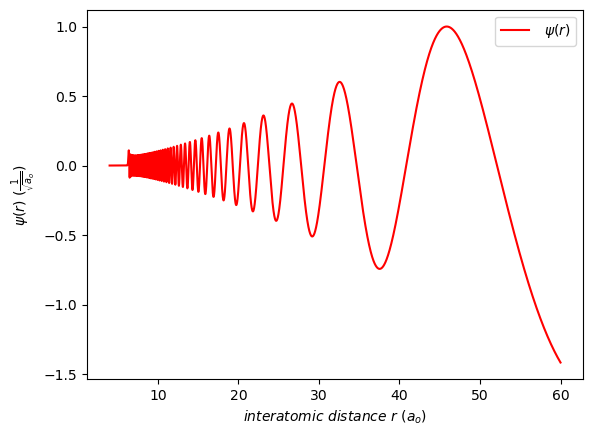

In [35]:
psi = np.zeros(pts)  # initializing psi(r) as array of zeros
Psi_1 = Numerov(Eo, pts) # wave function Psi
psi_1prime = np.gradient(Psi_1, r) # first posistion derivate of wave function Psi
plt.plot(r, Psi_1, label = f' $\\psi(r)$', color = 'red') 
#plt.plot(r, Vr*1e0, label = 'Scaled Lennard-Jones Potential', color = 'purple')
plt.xlabel('$ interatomic$ $distance$ $r$ $(a_{o})$')
plt.ylabel('$\\psi(r)$ ($\\frac{1}{\\sqrt{a_{o}}}$)')
plt.legend()

# Other Algorithms

# Scattering length definition

## $ -\frac{1}{a_{s}} =   \ lim_{k \to 0} (kcot\delta)$
## $ k = \sqrt{2\mu(E - V(r))} $
## $a_{s} =  \sqrt{\frac{\sigma}{\pi}}$ given $(E\ll Vo)$
## $\delta = k(r)a_{s}$ given $(E\ll Vo)$


# Finding the scattering phase shift $\delta$ 

## $\psi(r) = sin(kr + \delta), \frac{d\psi}{dr} = kcos(kr + \delta)$
## $\frac{\psi}{\frac{d\psi}{dr}} = \frac{1}{k}tan(kr + \delta)$
## $tan^{-1}(\frac{k\psi_{n}}{\frac{d\psi_{n}}{dr}}) = kr + \delta$
## $\delta = tan^{-1}(\frac{k\psi_{n}}{\frac{d\psi_{n}}{dr}}) - kr $
## $\delta = tan^{-1}(\frac{k\psi_{n}}{\frac{d\psi_{n}}{dr}}) - kr $

In [ ]:
Delta_numeric = []
knsq = []
as_delta = []
for j in range(N):
    for i in range(N):
        ksq = 2*mu*(E[i] - Vr)
        knsq.append(ksq[-1])
        PSI = wavefunction(E[i],N) # wave function to find using Numerov
        PSI_prime = np.gradient(PSI, r) # find derivative of PSI Numerov
        Delta = np.arctan((np.sqrt(ksq)*PSI)/(PSI_prime)) - np.sqrt(ksq)*r
        Delta_numeric.append(Delta[-1])
        as_delta.append(Delta_numeric[-1]/np.sqrt(knsq[-1]))

# Scattering Cross Section $ \sigma $

## $\sigma = \frac{\pi}{k^2} sin^2(\delta)$

# Harmonic Oscillator DVR

In [ ]:
def Hamiltonian_DVR(dx, Vc):
    # Build the Hamiltonian Matrix for Harmonic Oscillator using DVR
    # Takes in a xmin and xmax to build a grid, a spacing dx, and a cutoff energy Vc
    
    N = int(2*np.sqrt(2*Vc)*(1/dx)) # Number of pts
    if N % 2 == 0: # require N odd for symmetry around 0
        N += 1
        
    xmin = -1*np.sqrt(2*Vc) # xmin determined by Vc
    xmax = np.sqrt(2*Vc) # xmax determined by Vc
    xp = np.linspace(xmin, xmax, N) # box to determine Hamiltonian
    H_DVR = np.zeros((len(xp),len(xp))) # Initialize an empty matrix of zeros

    #print(f' shape of xp = {print(xp)}')
    #print(f' shape of H = {H_DVR.shape}')
    #print(H_DVR[0][0:3])
    #print(f' N = {N}')
    #print(f' len(xp) = {len(xp)}')
    #print(f' len(H) = {len(H_DVR)}, len(H[0]) = {len(H_DVR[0])}')
    #print(f' iterator range is {2*max(range(len(xp)/2), int(len(xp)/2) + 1))}')

    offset = int(len(xp)/2) # offset to ensure mapping is correct

    # NOTE on OFFSET: Since i = 0, +-1, +-2, ... we have to add offset so that when we index w/ numpy we correctly map the values, ie -n -> 0, -n + 1 -> 1, since Numpy starts its count at i=0
    
    for i in range(-1*int(len(xp)/2), int(len(xp)/2) + 1): # let i be the rows, start on a row, from -len(xp)/2 to len(xp)/2
        
        for j in range(-1*int(len(xp)/2), int(len(xp)/2) + 1): # Let j be the columns, for a given row i, run along columns and calculate Hij
            
            if i == j: # This will calculate diagonal components of H
                H_DVR[i + offset][j + offset] = (np.pi**2)*(1/6)*(1/(dx**2)) + (xp[i + offset]**2)*0.5 # Fill out diagonal elements according to DVR method
            
            if i != j: # This will calculate off-diagonal components of H
                H_DVR[i + offset][j + offset] = ((-1)**(i-j))*(1/(dx**2))*(1/((i-j)**2)) # Fill out off diagonal elements according to DVR method

    assert(np.allclose(H_DVR, np.transpose(H_DVR))) # Assert Hamilitonian is real symmetric
        

    return H_DVR

# Normalization Condition for positive eigenvalues, with different check

In [ ]:
for i in range(len(Heig)): # run through all eigenvectors corresponding to bound states
    for j in range(len(Heig)): # run through all other eigenvectors corresponding to bound states
        
        if i == j: # inner product should be close to 1
            phi_n = np.conjugate(Hvec[i])
            phi_m = Hvec[j]
            produit = phi_n*phi_m
            InnerProduct = np.trapz(produit, xpp)
            if InnerProduct - 1 >= tol:
                print(f' (n,m) = {(i,j)}')
                print(f'same indices no longer 1')
                break

        if i != j: # inner product should be close to 0
            phi_n = np.conjugate(Hvec[i])
            phi_m = Hvec[j]
            produit = phi_n*phi_m
            InnerProduct = np.trapz(produit, xpp)
            if InnerProduct >= tol:
                print(f' (n,m) = {(i,j)}')
                print(f'different indices no longer 0')
                break